# PCO. Analyse des données
## Compétences C1. 

![IllustrationAnalytics](Ressources_NB\IllustrationAnalytics.png)

Ce fichier contient l'analyse générale des données mises à disposition. A la fin de l'étude, le Dataset Final est exporté dans une base de données relationnelle et servira pour la création du modèle IA.

## Compétences
* **C1.** Qualifier les données grâce à des outils d’analyse et de visualisation de données en vue de vérifier leur adéquation avec le projet.

## Description générale des données
**Plusieurs fichiers (Version 2 et 3) sont à disposition comportant des données des utilisateurs jusqu'à 2017. Le but est ici de créer un fichier CSV unique qui sera ensuite intégré dans une base de données relationnelle type MySQL.**

La définition de l'attrition/renouvellement peut être délicate en raison du modèle d'abonnement de KKBox. Étant donné que la majorité de la durée d'abonnement de KKBox est de 30 jours, de nombreux utilisateurs se réabonnent chaque mois. Les champs clés pour déterminer l'attrition/le renouvellement sont *transaction date*, *membership expiration date*, et *is_cancel*. A noter que le champ *is_cancel* indique si un utilisateur annule activement un abonnement. L'annulation de l'abonnement n'implique pas que l'utilisateur s'est désabonné pour de bon. Un utilisateur peut annuler l'abonnement au service en raison d'un changement de plan de service ou pour d'autres raisons. Le critère de "churn" est l'absence d'un nouvel abonnement de service valide dans les 30 jours suivant l'expiration de l'abonnement actuel.

Le nombre d'utilisateurs uniques diffère d'un CSV à l'autre et une étude approfondie sur un Dataset global apporterait des biais dans la proportion d'individus désabonnés/abonnés. Ainsi, les études seront faites individuellement pour chaque CSV Transactions, Membres, Logs avec un merge de Train. De plus, le nombre d'utilisateur global sur les CSV Transactions et Logs est plus élevé que le nombre d'utilisateur unique, indiquant un aspect temporel des informations. Dans le cadre de ce projet, seule la dernière en date pour chaque membre sera pris en compte.


### transactions_v3.csv
Transactions des utilisateurs jusqu'au 28/02/2017.

* **msno**: utilisateur id
* **payment_method_id**: mode de paiement
* **payment_plan_days**: durée de l'abonnement en jours
* **plan_list_price**: en nouveau dollar de Taïwan (NTD)
* **actual_amount_paid**: en nouveau dollar de Taïwan (NTD)
* **is_auto_renew**
* **transaction_date**: format %Y%m%d Dernière transaction au 31/03/2017
* **membership_expire_date**: format %Y%m%d date d'expiration de l'abonnement
* **is_cancel**: si l'utilisateur a annulé ou non l'adhésion à cette transaction

### user_logs_v2.csv
Journaux d'utilisateurs quotidiens décrivant les comportements d'écoute d'un utilisateur. Données collectées jusqu'au 31/03/2017.

* **msno**: utilisateur id
* **date**: format %Y%m%d
* **num_25**: nombre de musique jouées moins de 25 % 
* **num_50**: nombre de musique jouées entre 25 % et 50 % 
* **num_75**:  nombre de musique jouées entre 50 % et 75 % 
* **num_985**:  nombre de musique jouées entre 75 % et 98.5 % 
* **num_100**: nombre de musique jouées sur 98,5% de la durée
* **num_unq**: nombre de musique uniques jouées
* **total_secs**:  nombre total de secondes écouté

### members_v3.csv
Informations de l'utilisateur. Notez que tous les utilisateurs de l'ensemble de données ne sont pas disponibles.

* **msno**: utilisateur id
* **city**: ville id
* **bd**: Age. Remarque : cette colonne contient des valeurs aberrantes allant de -7000 à 2015.
* **gender** : Genre de l'individu
* **registered_via**: Méthode d'enregistrement
* **registration_init_time**: Date d'enregistrement
* **expiration_date**: Date d'expiration d'abonnement, pris comme un instantané auquel le member.csv est extrait. Ne représentant pas le comportement de désabonnement réel.

### train_v2.csv
Contenant les identifiants des utilisateurs et s'ils ont quitté les services du site.

* **msno**: utilisateur id
* **is_churn**:  La variable cible. Le taux de désabonnement est défini comme si l'utilisateur n'a pas continué l'abonnement dans les 30 jours suivant l'expiration. is_churn = 1 signifie désabonnement, is_churn = 0 signifie renouvellement.

## Librairie

In [152]:
# Librairies standards de data-analyses:
    
import numpy as np
from numpy import set_printoptions
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy.stats import norm, skew
from scipy import stats
import statsmodels.api as sm
from scipy.stats import ttest_ind, ttest_rel


# sklearn modules Preprocessing:

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


# Librairies standards de data-visualisation:

import seaborn as sn
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib 
%matplotlib inline
color = sn.color_palette()
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from IPython.display import display
pd.options.display.max_columns = None
from dateutil.relativedelta import relativedelta
import datetime
from datetime import date, datetime
import re


# Filtre warnings:

import warnings 
warnings.filterwarnings("ignore")


# Coloration des graphes Seaborn:

colors = ['#440154', '#482475','#414487','#355F8D','#2A788E','#21918C','#22A884','#44BF70','#7AD151','#BDDF26','#FDE725']
red = '#fd8181'
blue = '#8198fd'

## Fonctions

In [2]:
# Fonction détection des valeurs manquantes:
def find_NaN(dataset):
    NaN = dataset.isnull().sum().to_frame('Valeurs Manquantes')
    NaN = NaN.loc[NaN['Valeurs Manquantes']>0]
    NaN['Pourcentage'] = [str(round((i*100)/len(dataset),1)) for i in NaN['Valeurs Manquantes']]
    NaN['Pourcentage'] = [i+' %' for i in NaN['Pourcentage']]
    if NaN.empty:
        return print(f'Aucune valeur manquante n\'est détectée sur ce dataset')
    else:
        return NaN
    
# Fonction transformation date int(YYYYMMDD) en str(YYYY-MM-DD):    
def Transform_date(serie):
    Liste = []
    for i in serie:
        i = str(i)
        y = i[:4]
        m = i[4:6]
        d = i[6:]
        i = f'{y}-{m}-{d}'
        Liste.append(i)

    return Liste

# Fonction transformation date str(YYYY-MM-DD) en int(YYYYMMDD):    
def Format_intdate(serie):
    Liste = []
    for i in serie:
        y = i[:4]
        m = i[5:7]
        d = i[8:]
        i = f'{y}{m}{d}'
        i = int(i)
        Liste.append(i)

    return Liste

def Transform_date_MonthYear(serie):
    Liste = []
    for i in serie:
        i = str(i)
        y = i[:4]
        m = i[4:6]
        i = f'{y}{m}'
        Liste.append(i)

    return Liste

# Différence entre 2 dates en jour:
def difference_dates(date1, date2):
    return abs(date2-date1).days

# Transformation datetime:
def TransformationToDate(serie):
    new_serie = [datetime.strptime(i, "%d-%m-%Y") for i in serie]
    return new_serie

# Affichage Plot avec 3 axes y sur Logs:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

# Affichage Plot Aggregate sur Logs:
def plot_aggregate(dataset, churn):
    fig, host = plt.subplots(figsize = (15,6))
    fig.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()

    par2.spines["right"].set_position(("axes", 1.2))

    make_patch_spines_invisible(par2)

    par2.spines["right"].set_visible(True)

    p1, = host.plot(dataset['utilisateur']['2017-03-01':'2017-03-30'].tolist(), label='Nombre Utilisateur', 
             lw = 3, alpha = 0.5, color = 'blue')
    p2, = par1.plot(dataset['sum']['2017-03-01':'2017-03-30'].tolist(), label='Somme d\'écoute par jour', 
             lw = 3, ls = '--', alpha = 0.5, color = 'red')
    p3, = par2.plot(dataset['mean']['2017-03-01':'2017-03-30'].tolist(), label='Moyenne d\'écoute par jour', 
             lw = 2, ls = ':', alpha = 0.5, color = 'purple')

    host.set_xlabel("Date")
    host.set_ylabel('Nombre Utilisateur', color='blue')
    par1.set_ylabel('Somme Temps d\'écoute en seconde', color='red')
    par2.set_ylabel('Moyenne Temps d\'écoute en seconde', color='purple')

    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)

    lines = [p1, p2, p3]

    host.legend(lines, [l.get_label() for l in lines])

    plt.title(f'Analyse temporelle sur les utilisateurs {churn}')
    plt.show()

# Pie Chart Proportion Churn:
def proportion_churn(dataset):
    labels = ['Abonnés', 'Désabonnés']
    colors = [blue, red]
    explode = (0, 0.2)

    fig, ax = plt.subplots()
    ax.pie(dataset['is_churn'].value_counts(), startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%', explode = explode, shadow=True)
    ax.set_title('Proportion d\'attrition', fontweight='bold')

    fig.set_figheight(5)
    fig.set_figwidth(5)
    fig.legend(loc='lower right', labels=labels, fontsize='medium')
    fig.tight_layout()
    
def plot_churn(dataset, feature):
    ChurnOnFeature = dataset.groupby([feature, 'is_churn']).size().unstack()
    ChurnOnFeature.rename(columns={0:'Abonnés', 1:'Désabonnés'}, inplace = True)

    colors = ['#8198fd','#fd8181']
    ax = (ChurnOnFeature.T*100.0/ChurnOnFeature.T.sum()).T.plot(kind='bar', width = 0.3, stacked = True, rot = 90, figsize = (15, 4), color = colors, grid=False)

    plt.ylabel('Proportion de Clients\n', horizontalalignment="center", fontstyle = "normal", fontsize="large", fontfamily = "sans-serif")
    plt.xlabel(feature+'\n', horizontalalignment="center", fontstyle = "normal", fontsize="large", fontfamily = "sans-serif")
    plt.title(f'Répartition de l\'Attrition sur {feature}\n', horizontalalignment="center", fontstyle = "normal", fontsize="22", fontfamily = "sans-serif")
    plt.legend(loc='upper right', fontsize = "medium")
    plt.xticks(rotation=0, horizontalalignment="center")
    plt.yticks(rotation=0, horizontalalignment="right")

    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

## Initialisation des fichiers CSV mis à disposition
Une première analyse a été faite sur la Version 1 des CSV avec un ensemble de données beaucoup plus conséquent. L'analyse c'était d'ailleurs portée sur les 8M premières lignes de *user_logs.csv* et *transactions.csv*, des données antérieures à Mars 2017. Du fait de l'importation en base de données, l'étude se concentre uniquement sur l'analyse des données de Mars 2017.

In [3]:
# Logs:
df_logs = pd.read_csv('data/user_logs_v2.csv')
logs = df_logs.copy()
print(f"Nombre de ligne total :\t\t {len(logs.msno)}")
print(f"Nombre d'utilisateur unique :\t {len(logs.msno.unique())}")
logs.head()

Nombre de ligne total :		 18396362
Nombre d'utilisateur unique :	 1103894


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


In [4]:
# Transactions:
df_transactions = pd.read_csv('data/transactions_v2.csv')
transactions = df_transactions.copy()
print(f"Nombre de ligne total :\t\t {len(transactions.msno)}")
print(f"Nombre d'utilisateur unique :\t {len(transactions.msno.unique())}")
transactions.head()

Nombre de ligne total :		 1431009
Nombre d'utilisateur unique :	 1197050


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,20170131,20170504,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150809,20190412,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,20170303,20170422,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,20170329,20170331,1
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,20170323,20170423,0


In [5]:
# Members:
df_members = pd.read_csv('data/members_v3.csv')
members = df_members.copy()
print(f"Nombre de ligne total :\t\t {len(members.msno)}")
print(f"Nombre d'utilisateur unique :\t {len(members.msno.unique())}")
members.head()

Nombre de ligne total :		 6769473
Nombre d'utilisateur unique :	 6769473


,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915


In [6]:
# Train:
df_train = pd.read_csv('data/train_v2.csv')
train = df_train.copy()
print(f"Nombre de ligne total :\t\t {len(train.msno)}")
print(f"Nombre d'utilisateur unique :\t {len(train.msno.unique())}")
train.head()

Nombre de ligne total :		 970960
Nombre d'utilisateur unique :	 970960


,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


In [7]:
# Réduction de l'ID utilisateur msno à 12 caractères:

logs['msno'] = [i[10:22] for i in logs['msno']]
print("Logs :")
print(f"Nombre d'utilisateur unique :\t {len(df_logs.msno.unique())}")
print(f"Nombre d'utilisateur unique :\t {len(logs.msno.unique())}\n")

transactions['msno'] = [i[10:22] for i in transactions['msno']]
print("Transactions :")
print(f"Nombre d'utilisateur unique :\t {len(df_transactions.msno.unique())}")
print(f"Nombre d'utilisateur unique :\t {len(transactions.msno.unique())}\n")

members['msno'] = [i[10:22] for i in members['msno']]
print("Members :")
print(f"Nombre d'utilisateur unique :\t {len(df_members.msno.unique())}")
print(f"Nombre d'utilisateur unique :\t {len(members.msno.unique())}\n")

train['msno'] = [i[10:22] for i in train['msno']]
print("Train :")
print(f"Nombre d'utilisateur unique :\t {len(df_train.msno.unique())}")
print(f"Nombre d'utilisateur unique :\t {len(train.msno.unique())}\n")

Logs :
Nombre d'utilisateur unique :	 1103894
Nombre d'utilisateur unique :	 1103894

Transactions :
Nombre d'utilisateur unique :	 1197050
Nombre d'utilisateur unique :	 1197050

Members :
Nombre d'utilisateur unique :	 6769473
Nombre d'utilisateur unique :	 6769473

Train :
Nombre d'utilisateur unique :	 970960
Nombre d'utilisateur unique :	 970960



## 1. Analyses sur Logs
Le journal de l'utilisateur sur le mois de Mars 2017, comportant le nombre de chanson écouté à 25%, 50%, 75%, 98.5% et entièrement. De plus, le nombre de chanson unique joué dans la journée est aussi comptabilisé.

In [8]:
# Recherche de valeurs manquantes:
find_NaN(logs)

Aucune valeur manquante n'est détectée sur ce dataset


In [9]:
# Caractéristiques des variables:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18396362 entries, 0 to 18396361
Data columns (total 9 columns):
 #   Column      Dtype  
---  ------      -----  
 0   msno        object 
 1   date        int64  
 2   num_25      int64  
 3   num_50      int64  
 4   num_75      int64  
 5   num_985     int64  
 6   num_100     int64  
 7   num_unq     int64  
 8   total_secs  float64
dtypes: float64(1), int64(7), object(1)
memory usage: 1.2+ GB


In [10]:
# Vérification pour détecter d'éventuelles anomalies:
logs.describe()

,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07
mean,2.017032e+07,6.191401e+00,1.508789e+00,9.413759e-01,1.079905e+00,3.028246e+01,2.903615e+01,7.904814e+03
std,8.916720e+00,1.342827e+01,3.908539e+00,1.924840e+00,3.518409e+00,4.203641e+01,3.219866e+01,1.013632e+04
min,2.017030e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e-03
25%,2.017031e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,8.000000e+00,1.959944e+03
50%,2.017032e+07,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.700000e+01,1.800000e+01,4.582990e+03
75%,2.017032e+07,7.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,3.700000e+01,3.800000e+01,9.848441e+03
max,2.017033e+07,5.639000e+03,9.120000e+02,5.080000e+02,1.561000e+03,4.110700e+04,4.925000e+03,9.194059e+06


### Anomalies détectées

In [11]:
# Détection d'anomalies sur Total_sec:
logs_total_secsMax = logs.loc[logs['total_secs']==logs['total_secs'].max()]
display(logs_total_secsMax)
print(f'Ecoute sur le mois de Mars : {round((logs.total_secs.max()/3600/24), 2)} jours')

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
11534622,p+HF5X/IzTit,20170324,227,104,95,108,41107,1510,9194058.522


Ecoute sur le mois de Mars : 106.41 jours


Cette vérification présente certaines valeurs abérrantes comme Total_secs Maximale retrouvé chez un individu qui cumule près de **106 jours d'écoute sur une journée**. Cela laisse supposer que le décompte n'a pas été réinitialisé. Le tableau de description montre aussi des valeurs abérrantes dans les autres catégories. Par exemple la mediane est au niveau de l'unité numérique pour chacune des variables mais avec des valeurs maximales allant jusqu'au millier voire dizaine de millier (Plusieurs Log10 de différence).

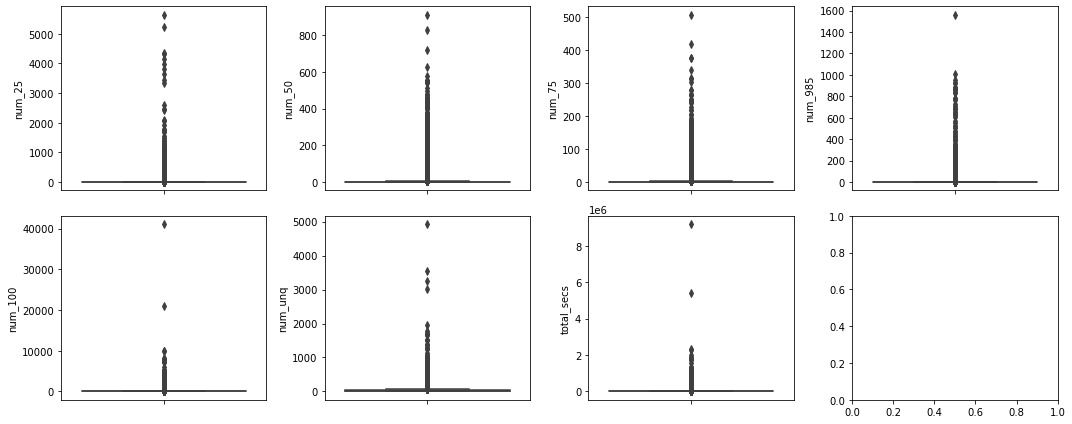

In [12]:
# BoxPlot sur les variables Logs:
fig, axes = plt.subplots(2, 4, figsize = [15,6])
var_logs = [logs.num_25, logs.num_50, logs.num_75, logs.num_985, logs.num_100, logs.num_unq, logs.total_secs]
ax_plot = 0

for feature in var_logs:
    i, j = divmod(ax_plot, 4)
    sn.boxplot(y=feature, ax=axes[i, j])
    ax_plot+=1

plt.tight_layout()    
plt.show()

La question qui se pose est de maintenant savoir si ces variables seraient utiles à la conception du futur modèle. Une analyse de la quantité de valeur abérrantes est donc envisagée. D'après la littérature, cette étude peut s'orienté sur la définition d'un seuil grace au Z-Score (nombre d’écarts types par rapport à l’estimation moyenne). Le seuil ainsi choisi sera de 3 écart-types.

Bien que la part de valeurs abérrantes soit restreint, la fonction de modification des valeurs abérrantes sera tout de même utilisé. La médiane sera privilégié pour remplacer les valeurs jugées abérrantes avec pour seuil le Z-Score.

In [13]:
Features = [logs.num_25, logs.num_50, logs.num_75, logs.num_985, logs.num_100, logs.num_unq, logs.total_secs]
name_features = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']

Outliers_del = []

for i, name in zip(Features, name_features) :
    Identify_outliers = []
    
    # Calcul du Z Score
    logs['Z_score']=(i-i.mean())/i.std()
    z = len(logs[(logs['Z_score']>3)])
    print(f'{z}\t valeurs abérrantes ({round(z*100/len(i),2)} %)\t sur ({len(i)}) détectées pour {name}')
    
    # Identification des valeurs abérrantes
    Outliers_del.append(logs[(logs['Z_score']>3) | (logs['Z_score']<-3)].shape[0])
    Identify_outliers = logs[(logs['Z_score']>3) | (logs['Z_score']<-3)].index
    R_with_Median = logs[(logs['Z_score']<3) & (logs['Z_score']>-3)][name].median()
    
    # Remplacement par la médiane
    logs.loc[Identify_outliers, name] = R_with_Median
    
print(f'\nNombre total de valeurs abérrantes modifiées :\t {sum(Outliers_del)}')
logs = logs.drop(['Z_score'], 1)

277603	 valeurs abérrantes (1.51 %)	 sur (18396362) détectées pour num_25
210716	 valeurs abérrantes (1.15 %)	 sur (18396362) détectées pour num_50
272925	 valeurs abérrantes (1.48 %)	 sur (18396362) détectées pour num_75
91284	 valeurs abérrantes (0.5 %)	 sur (18396362) détectées pour num_985
332917	 valeurs abérrantes (1.81 %)	 sur (18396362) détectées pour num_100
379625	 valeurs abérrantes (2.06 %)	 sur (18396362) détectées pour num_unq
338298	 valeurs abérrantes (1.84 %)	 sur (18396362) détectées pour total_secs

Nombre total de valeurs abérrantes modifiées :	 1903368


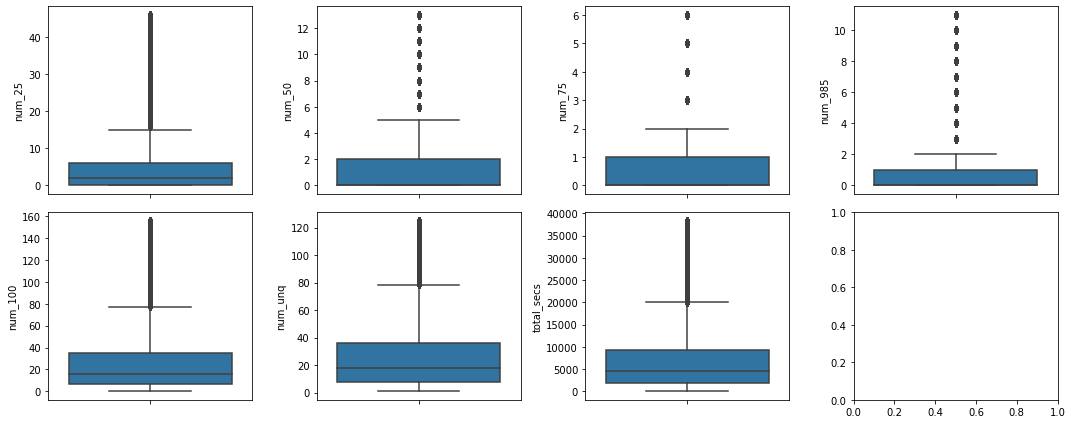

In [14]:
# BoxPlot sur les variables Logs modifiés:
fig, axes = plt.subplots(2, 4, figsize = [15,6])
var_logs = [logs.num_25, logs.num_50, logs.num_75, logs.num_985, logs.num_100, logs.num_unq, logs.total_secs]
ax_plot = 0

for feature in var_logs:
    i, j = divmod(ax_plot, 4)
    sn.boxplot(y=feature, ax=axes[i, j])
    ax_plot+=1

plt.tight_layout()    
plt.show()

Les données modifiées altèrent moins la distribution des valeurs pour chaque features.

### Analyses sur la globalité du mois de Mars sur Utilisateurs

**Une précédente analyse a été effectuée sur les différences d'écoutes journalières entre populations désabonnées et abonnées.**

Les données sont regroupées sur tout le mois de Mars. Ainsi, pour chacune de ces features, la somme, l'écart-type et la moyenne seront générés. Ces nouveaux paramètres seront comparé entre la "population" d'individu restant abonné et la "population" qui s'est désabonné.

#### Démarche de l'approche données utilisateurs (exemple, données fictives):
![Demarche_analyse_logs](Ressources_NB\DemarcheAnalyseUtilisateurs.png)

In [17]:
# Résumé de l'activité sur le mois de Mars 2017:
logs = logs.drop(['date'], 1)

LogsSum = logs.groupby('msno').sum().reset_index()
LogsSum.rename(columns={'num_25':'num_25Sum','num_50':'num_50Sum','num_75':'num_75Sum','num_985':'num_985Sum',
                                  'num_100':'num_100Sum','num_unq':'num_unqSum','total_secs':'total_secsSum'}, inplace = True)

LogsMean = logs.groupby('msno').mean().reset_index()
LogsMean.rename(columns={'num_25':'num_25Mean','num_50':'num_50Mean','num_75':'num_75Mean','num_985':'num_985Mean',
                                  'num_100':'num_100Mean','num_unq':'num_unqMean','total_secs':'total_secsMean'}, inplace = True)

days_count = logs.groupby('msno').size().to_frame('count')
days_count = pd.merge(logs, days_count, on='msno', how='inner')
days_count = days_count[['msno', 'count']]
days_count = days_count.groupby('msno').mean()

logs = pd.merge(LogsSum, LogsMean, on='msno', how='inner')
logs = pd.merge(logs, days_count, on='msno', how='inner')

print(f'Nombres de lignes : {len(logs)}')
logs.head()

Nombres de lignes : 1103894


,msno,num_25Sum,num_50Sum,num_75Sum,num_985Sum,num_100Sum,num_unqSum,total_secsSum,num_25Mean,num_50Mean,num_75Mean,num_985Mean,num_100Mean,num_unqMean,total_secsMean,count
0,+++IubgjAxvn,200.0,47.0,42.0,39.0,747.0,684.0,220954.5830,6.896552,1.62069,1.448276,1.344828,25.758621,23.586207,7619.123552,29
1,+++KGJ1Vi2lH,212.0,37.0,38.0,34.0,401.0,585.0,116986.9040,7.851852,1.37037,1.407407,1.259259,14.851852,21.666667,4332.848296,27
2,+++MqaETxAaV,41.0,9.0,3.0,9.0,624.0,509.0,140733.2220,1.708333,0.37500,0.125000,0.375000,26.000000,21.208333,5863.884250,24
3,+++jS2GnZPyH,26.0,6.0,4.0,4.0,77.0,106.0,21055.8410,1.733333,0.40000,0.266667,0.266667,5.133333,7.066667,1403.722733,15
4,+++l4M/sEnP0,219.0,39.0,32.0,34.0,2201.0,1792.0,542811.6555,7.300000,1.30000,1.066667,1.133333,73.366667,59.733333,18093.721850,30


### Merge Train et Logs Grouby Msno

In [18]:
# Merge Train et Logs Grouby Msno: 
MergeTrainLogs_gp = pd.merge(train, logs, on='msno', how='inner')
print(f'Nombres de lignes : {len(MergeTrainLogs_gp)}')

# Recherche de valeurs manquantes:
find_NaN(MergeTrainLogs_gp)

MergeTrainLogs_gp.head()

Nombres de lignes : 754551
Aucune valeur manquante n'est détectée sur ce dataset


,msno,is_churn,num_25Sum,num_50Sum,num_75Sum,num_985Sum,num_100Sum,num_unqSum,total_secsSum,num_25Mean,num_50Mean,num_75Mean,num_985Mean,num_100Mean,num_unqMean,total_secsMean,count
0,zClkFzU2xasm,1,50.0,4.0,6.0,10.0,318.0,208.0,80598.557,4.545455,0.363636,0.545455,0.909091,28.909091,18.909091,7327.141545,11
1,INFEYZTR05pr,1,0.0,4.0,2.0,0.0,26.0,30.0,6986.509,0.000000,0.666667,0.333333,0.000000,4.333333,5.000000,1164.418167,6
2,T1p21ltZC3Ch,1,190.0,57.0,32.0,22.0,205.0,432.0,67810.467,9.500000,2.850000,1.600000,1.100000,10.250000,21.600000,3390.523350,20
3,Z5xG6BypqX80,1,9.0,7.0,4.0,4.0,962.0,548.0,239882.241,0.600000,0.466667,0.266667,0.266667,64.133333,36.533333,15992.149400,15
4,wrSExE63/ome,1,6.0,1.0,1.0,4.0,37.0,48.0,10110.665,1.500000,0.250000,0.250000,1.000000,9.250000,12.000000,2527.666250,4


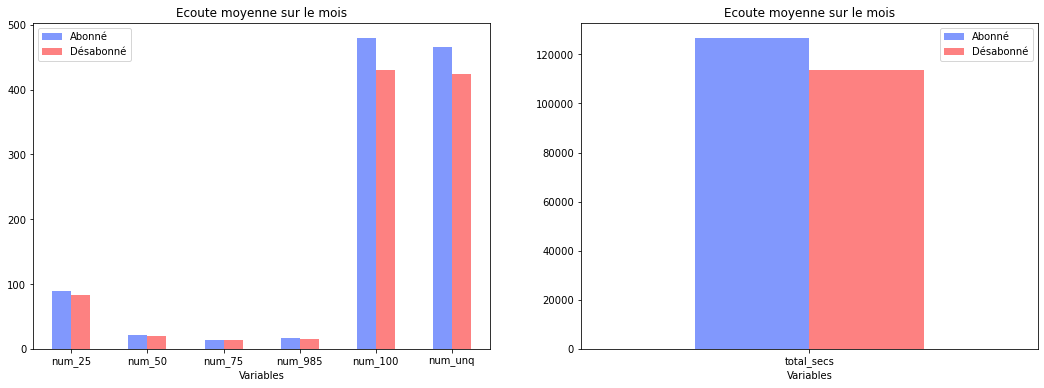

In [19]:
# Comparaison sur les différentes variables:
MergeTrainLogs_0_gp = MergeTrainLogs_gp.loc[MergeTrainLogs_gp['is_churn'] == 0]
MergeTrainLogs_1_gp = MergeTrainLogs_gp.loc[MergeTrainLogs_gp['is_churn'] == 1]

Churn = ['Variables','Abonné', 'Désabonné']
num_25 = ['num_25', round(MergeTrainLogs_0_gp.num_25Sum.mean(),2), round(MergeTrainLogs_1_gp.num_25Sum.mean(),2)]
num_50 = ['num_50', round(MergeTrainLogs_0_gp.num_50Sum.mean(),2), round(MergeTrainLogs_1_gp.num_50Sum.mean(),2)]
num_75 = ['num_75', round(MergeTrainLogs_0_gp.num_75Sum.mean(),2), round(MergeTrainLogs_1_gp.num_75Sum.mean(),2)]
num_985 = ['num_985', round(MergeTrainLogs_0_gp.num_985Sum.mean(),2), round(MergeTrainLogs_1_gp.num_985Sum.mean(),2)]
num_100 = ['num_100', round(MergeTrainLogs_0_gp.num_100Sum.mean(),2), round(MergeTrainLogs_1_gp.num_100Sum.mean(),2)]
num_unq = ['num_unq', round(MergeTrainLogs_0_gp.num_unqSum.mean(),2), round(MergeTrainLogs_1_gp.num_unqSum.mean(),2)]
total_secs = ['total_secs', round(MergeTrainLogs_0_gp.total_secsSum.mean(),2), round(MergeTrainLogs_1_gp.total_secsSum.mean(),2)]

variables = [num_25, num_50, num_75, num_985, num_100, num_unq, total_secs]

Comparaison = pd.DataFrame(variables, columns=Churn).set_index('Variables')

fig, axes = plt.subplots(figsize=(18,6), nrows=1, ncols=2)
Comparaison[:6].plot(ax = axes[0], kind="bar", color = [blue, red], rot = 0).set_title('Ecoute moyenne sur le mois')
Comparaison[6:].plot(ax = axes[1], kind="bar", color = [blue, red], rot = 0).set_title('Ecoute moyenne sur le mois')
plt.show()

Globalement, la population d'utilisateurs désabonnés écoutait en moyenne moins de musique sur le mois de Mars que la population abonnée. En revanche, cette première catégorie d'utilisateur écoutait en moyenne plus de musique par jour. Les utilisateurs abonnés écoutaient en moyenne moins de musique par jour mais au final plus sur le mois. Ainsi, ils utilisaient davantage le service sur le mois que les individus désabonnés. 

L'analyse se propose d'effectuée un *test T (Welch’s t-test)* afin de voir si ces différences sont significatives.

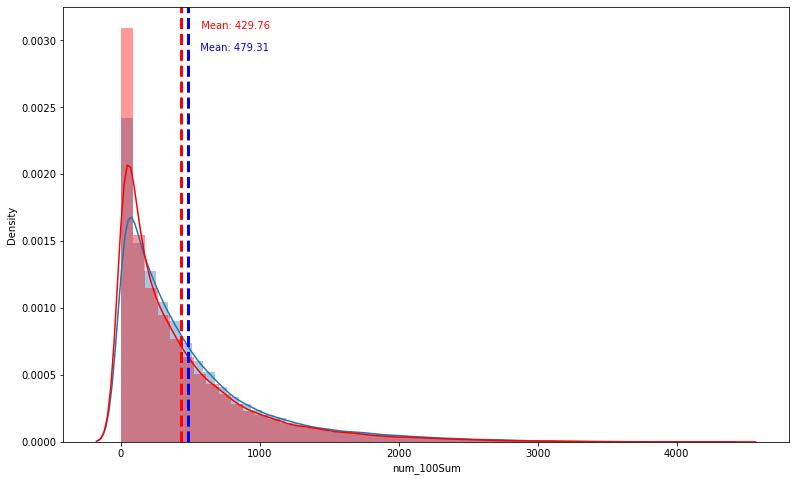

In [20]:
# Répartition sur échantillons:
echantillon = 60000

plt.figure(figsize=(13, 8))
ax1 = sn.distplot(MergeTrainLogs_0_gp.num_100Sum.sample(n=echantillon, random_state=40))
ax2 = sn.distplot(MergeTrainLogs_1_gp.num_100Sum.sample(n=echantillon, random_state=40), color = 'red')

plt.axvline(MergeTrainLogs_0_gp.num_100Sum.sample(n=echantillon, random_state=40).mean(),
            color ='blue', linestyle='dashed', linewidth=3)
_, max_ = plt.ylim()

plt.text(MergeTrainLogs_0_gp.num_100Sum.mean() + MergeTrainLogs_0_gp.num_100Sum.mean() / 10,
         max_ - max_ / 10,
         "  Mean: {:.2f}".format(MergeTrainLogs_0_gp.num_100Sum.mean()), color = 'blue')

plt.axvline(MergeTrainLogs_1_gp.num_100Sum.sample(n=echantillon, random_state=40).mean(),
            color ='red', linestyle='dashed', linewidth=3)

plt.text(MergeTrainLogs_1_gp.num_100Sum.mean() + MergeTrainLogs_1_gp.num_100Sum.mean() / 4,
         max_ - max_ / 20,
         "  Mean: {:.2f}".format(MergeTrainLogs_1_gp.num_100Sum.mean()), color = 'red')

plt.show()

In [21]:
print('p-value < 0.05 (risque alpha) = H0 rejeté : Différence significative entre les deux groupes.\n')

features_test = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']

series_0 = [MergeTrainLogs_0_gp.num_25Sum, MergeTrainLogs_0_gp.num_50Sum, MergeTrainLogs_0_gp.num_75Sum,
            MergeTrainLogs_0_gp.num_985Sum, MergeTrainLogs_0_gp.num_100Sum, MergeTrainLogs_0_gp.num_unqSum,
            MergeTrainLogs_0_gp.total_secsSum]

series_1 = [MergeTrainLogs_1_gp.num_25Sum, MergeTrainLogs_1_gp.num_50Sum, MergeTrainLogs_1_gp.num_75Sum,
            MergeTrainLogs_1_gp.num_985Sum, MergeTrainLogs_1_gp.num_100Sum, MergeTrainLogs_1_gp.num_unqSum,
            MergeTrainLogs_1_gp.total_secsSum]

for name, i, j in zip(features_test, series_0, series_1):
    print(f'P-value {name} :\t {ttest_ind(i.sample(n=echantillon, random_state=40), j.sample(n=echantillon, random_state=40), equal_var = False)[1]}')

p-value < 0.05 (risque alpha) = H0 rejeté : Différence significative entre les deux groupes.

P-value num_25 :	 7.556132711242168e-36
P-value num_50 :	 6.11420263017297e-29
P-value num_75 :	 3.4613038979038145e-41
P-value num_985 :	 2.210091041110495e-34
P-value num_100 :	 1.732248877137433e-70
P-value num_unq :	 6.405090000987455e-70
P-value total_secs :	 9.822568605636825e-74


## 2. Analyses sur Members 
Le Dataset Members comprend des données sur l'Age (*bd* : seule variable quantitative - discrète), le sexe (*gender*), la méthode d'enregistrement de compte (*registered_via*) (variables nominales) et la date d'enregistrement (*registration_init_time*). 

In [22]:
# Recherche de valeurs manquantes:
find_NaN(members)

,Valeurs Manquantes,Pourcentage
gender,4429505,65.4 %


In [23]:
# Caractéristiques des variables:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6769473 entries, 0 to 6769472
Data columns (total 6 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   msno                    object
 1   city                    int64 
 2   bd                      int64 
 3   gender                  object
 4   registered_via          int64 
 5   registration_init_time  int64 
dtypes: int64(4), object(2)
memory usage: 309.9+ MB


### Analyse sur âge *bd*

La seule variable quantitative est *bd*, qui renseigne sur l'âge des utilisateurs. Sur la description des données, *bd* présente des valeurs abérrantes (Valeur minimale : -7168 ans; Valeur maximale : 2016 ans). De façon arbitraire, les valeurs considérées comme abérrantes sont celles situées hors d'un intervalle convenable de 10 - 70 ans.

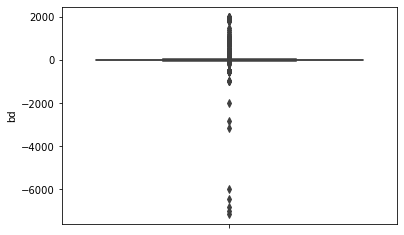

In [24]:
# Répartion des valeurs:
sn.boxplot(y=members.bd)
plt.show()

In [25]:
# Nettoyage des outliers:
members['bd'] = [i if 10 < i < 70 else -1 for i in members['bd']]
print(f'Part de valeurs abérrantes hors de l\'intervalle arbitraire après conversion est de : {round((members.bd.value_counts()[-1])*100/len(members),1)} %')

Part de valeurs abérrantes hors de l'intervalle arbitraire après conversion est de : 67.3 %


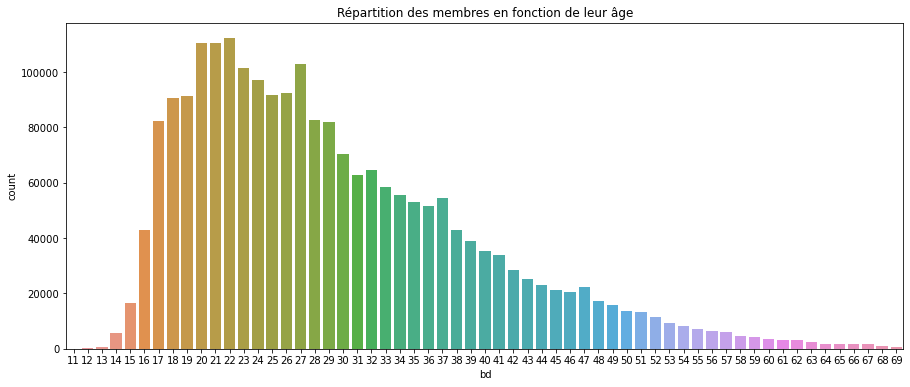

Mediane : 27 ans
Moyenne : 29 ans


In [26]:
# Countplot sur bd hors valeurs abérrantes:
plt.figure(figsize = (15, 6))
sn.countplot(x='bd', data = members[members['bd']!=-1]).set_title('Répartition des membres en fonction de leur âge')
plt.show()

print(f'Mediane : {int(members[members.bd!=-1].bd.median())} ans')
print(f'Moyenne : {int(members[members.bd!=-1].bd.mean())} ans')

### Analyse sur le Genre (*gender*)
La recherche des valeurs manquantes a montré que 65% des données sur le genre des utilisateurs étaient absentes. L'analyse sommaire se fera sur les données détaillées :

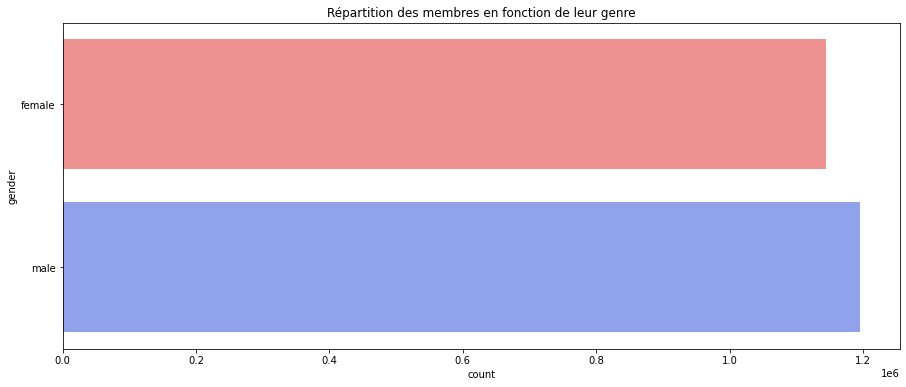

In [27]:
# Countplot sur gender hors valeurs abérrantes:
plt.figure(figsize = (15, 6))
color_g = [red, blue]
sn.countplot(y='gender', data = members[members['gender']!='inconnu'], palette = color_g).set_title('Répartition des membres en fonction de leur genre')
plt.show()

Il existe une légère différence dans la proportion d'individu. Le service comptait plus d'hommes que de femmes parmi les utilisateur de la plateforme. Toutefois, l'analyse ne peut pas mesurer la réelle proportion du fait du taux de données manquantes considérable sur cette variable.

### Analyse sur *City*

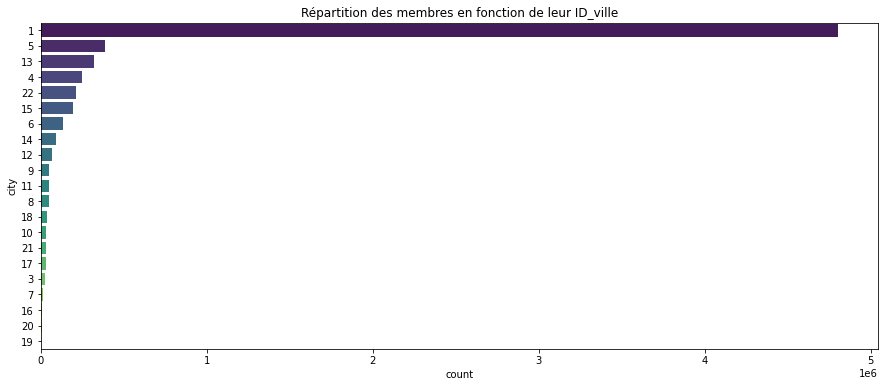

Les utilisateurs habitent en très grande majorité dans l'ID_ville 1 à plus de 71.0 %


In [28]:
# Countplot sur city:
plt.figure(figsize = (15, 6))
sn.countplot(y='city', data = members, order = members.city.value_counts().index,  palette = 'viridis').set_title('Répartition des membres en fonction de leur ID_ville')
plt.show()
print(f'Les utilisateurs habitent en très grande majorité dans l\'ID_ville 1 à plus de {round(members.city.value_counts()[1]*100/len(members), 1)} %')

### Analyse sur la méthode d'enregistrement des utilisateurs (*registered_via*)
La variable *registered_via* contient les ID de la méthode d'enregistrement du compte utilisateur. Les valeurs sont donc de type nominale :

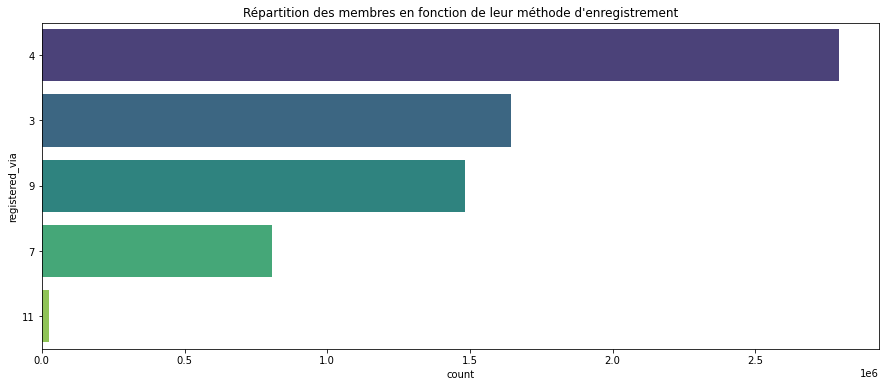

In [29]:
# Countplot sur registered_via:
plt.figure(figsize = (15, 6))
sn.countplot(y='registered_via', data = members, order = members.registered_via.value_counts()[:5].index, palette = 'viridis').set_title('Répartition des membres en fonction de leur méthode d\'enregistrement')
plt.show()

Les 4 premières méthodes d'enregistrement choisies représentent près de 99.4 % des utilisateurs.

### Analyse sur la méthode d'enregistrement des utilisateurs (*registration_init_time*)
La variable *registration_init_time* contient la date d'enregistrement du compte utilisateur. Les valeurs seront transformé en format datetime et basé sur le mois d'ouverture du compte :

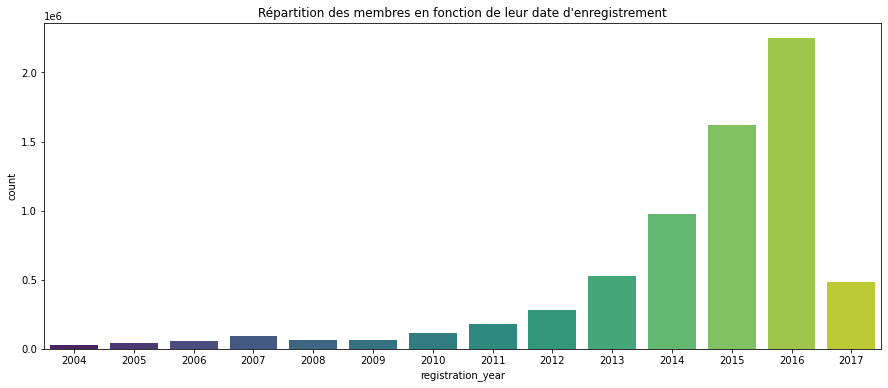

In [30]:
liste = []
for i in members['registration_init_time']:
    liste.append(str(i))
    
members['registration_year'] = [int(i[:4]) for i in liste]

# Countplot sur registration_init_time:
plt.figure(figsize = (15, 6))
sn.countplot(x='registration_year', data = members, palette = 'viridis').set_title('Répartition des membres en fonction de leur date d\'enregistrement')
plt.show()

Le nombre d'ouverture de compte utilisateur évolution de façon exponentielle au fil des ans.

### Merge Train et Members

In [31]:
# Merge Train et Members
MergeTrainMembers = pd.merge(train, members, on='msno', how='inner')
print(f"Nombre d'utilisateur unique :\t {len(MergeTrainMembers.msno.unique())}\n")

# Recherche de valeurs manquantes:
find_NaN(MergeTrainMembers)

MergeTrainMembers.head()

Nombre d'utilisateur unique :	 860967



,msno,is_churn,city,bd,gender,registered_via,registration_init_time,registration_year
0,zClkFzU2xasm,1,5,28,male,3,20131223,2013
1,INFEYZTR05pr,1,13,20,male,3,20131223,2013
2,T1p21ltZC3Ch,1,13,18,male,3,20131227,2013
3,JKFrTc7iR9ZY,1,1,-1,NaN,7,20140109,2014
4,Z5xG6BypqX80,1,13,35,female,7,20140125,2014


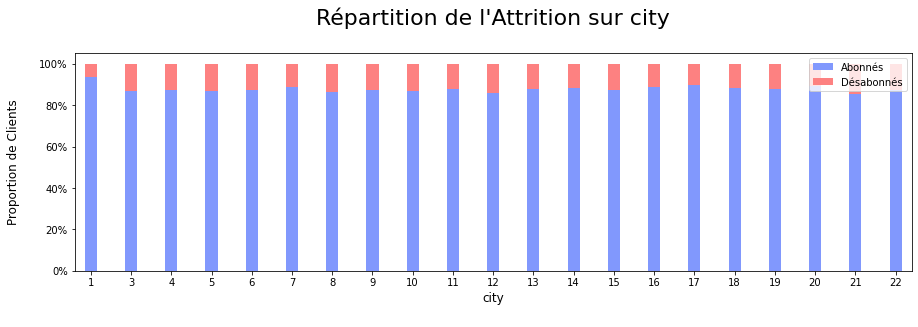

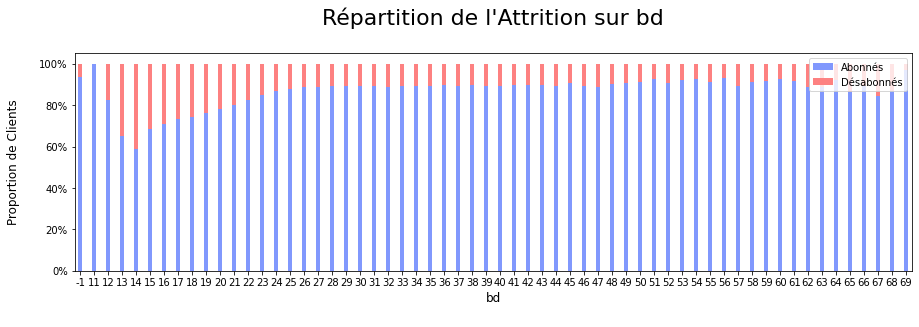

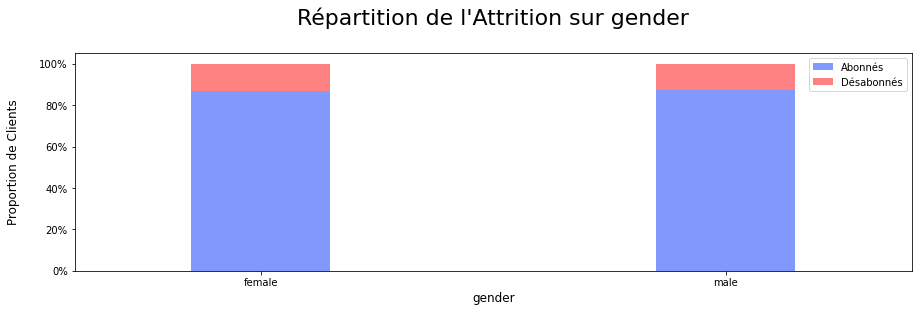

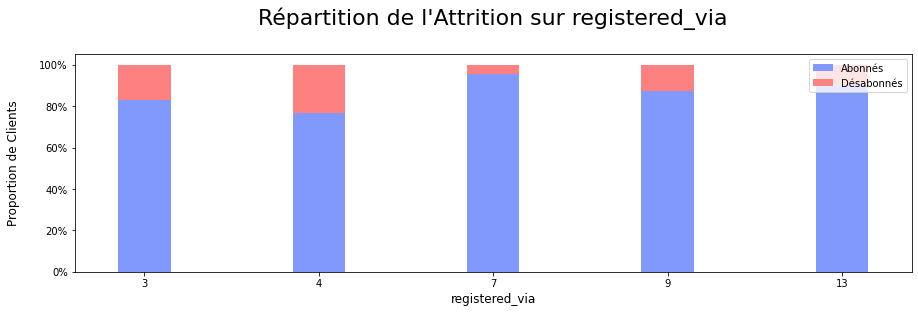

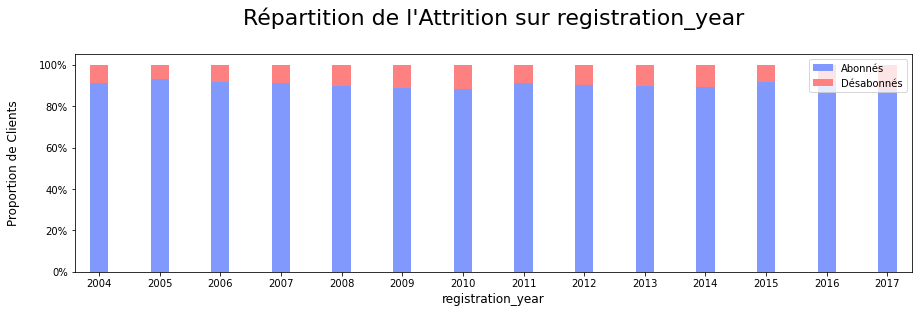

In [32]:
plot_churn(MergeTrainMembers, 'city')
plot_churn(MergeTrainMembers, 'bd')
plot_churn(MergeTrainMembers, 'gender')
plot_churn(MergeTrainMembers, 'registered_via')
plot_churn(MergeTrainMembers, 'registration_year')

**City** : La répartition des utilisateurs abonnés/désabonnés, est équivalente en fonction des villes. Dans cette première analyse, la localisation de l'utilisateur ne doit pas influencer sur l'attrition.

**Bd** : La proportion d'utilisateur ayant une plus forte propention à quitter ces services sont agés de 11 à 25 ans. La proportion de membres se désabonnant pour plus de 30 jours est similaire dans les autres catégories d'âge.

**Gender** : La part d'utilisateur qu'ils soient Homme ou Femme quittant les services de streaming est la même. Dans cette première analyse, le genre ne doit pas influencer sur l'attrition.

**Register_via** : La proportion d'individus utilisant la méthode d'enregistrement 7 (qui plus est, majoritaire) est moins enclin à partir. A l'inverse, elle est plus importante sur la méthode d'enregistrement 4 (6% des utilisateurs).

**Registration_year** : La répartition des utilisateurs abonnés/désabonnés, est équivalente en fonction de leur date d'enregistrement. Dans cette première analyse, cette variable n'influence pas sur l'attrition. 

## 3. Analyses sur Transactions
Le dataset Transactions ne présente pas de variable quantitative. Ces catégories contiennent des données de type int64 et forment des variables de nature temporelle, ordinale, binaire et nominale.

In [33]:
# Recherche de valeurs manquantes:
find_NaN(transactions)

Aucune valeur manquante n'est détectée sur ce dataset


In [34]:
# Caractéristiques des variables:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431009 entries, 0 to 1431008
Data columns (total 9 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   msno                    1431009 non-null  object
 1   payment_method_id       1431009 non-null  int64 
 2   payment_plan_days       1431009 non-null  int64 
 3   plan_list_price         1431009 non-null  int64 
 4   actual_amount_paid      1431009 non-null  int64 
 5   is_auto_renew           1431009 non-null  int64 
 6   transaction_date        1431009 non-null  int64 
 7   membership_expire_date  1431009 non-null  int64 
 8   is_cancel               1431009 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 98.3+ MB


In [35]:
# Vérification pour détecter d'éventuelles anomalies:
transactions.describe()

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
count,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06
mean,3.791835e+01,6.601770e+01,2.817870e+02,2.813172e+02,7.853025e-01,2.016848e+07,2.017110e+07,2.455121e-02
std,4.964805e+00,1.024864e+02,4.351861e+02,4.354200e+02,4.106124e-01,4.858797e+03,3.032367e+03,1.547529e-01
min,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.015010e+07,2.016042e+07,0.000000e+00
25%,3.600000e+01,3.000000e+01,9.900000e+01,9.900000e+01,1.000000e+00,2.017023e+07,2.017041e+07,0.000000e+00
50%,4.000000e+01,3.000000e+01,1.490000e+02,1.490000e+02,1.000000e+00,2.017031e+07,2.017042e+07,0.000000e+00
75%,4.100000e+01,3.000000e+01,1.490000e+02,1.490000e+02,1.000000e+00,2.017032e+07,2.017050e+07,0.000000e+00
max,4.100000e+01,4.500000e+02,2.000000e+03,2.000000e+03,1.000000e+00,2.017033e+07,2.036102e+07,1.000000e+00


### Analyse sur la méthode de paiement des utilisateurs (*payment_method_id*)

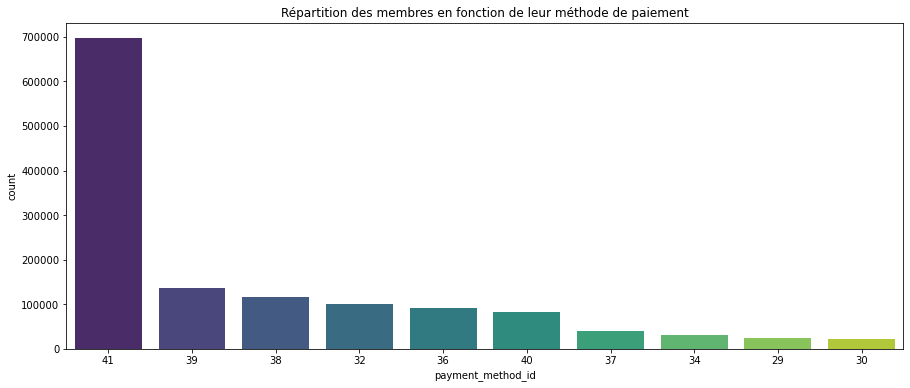

In [36]:
# Countplot sur payment_method_id:
plt.figure(figsize = (15, 6))
sn.countplot(x='payment_method_id', data = transactions, order = transactions.payment_method_id.value_counts()[:10].index, palette = 'viridis').set_title('Répartition des membres en fonction de leur méthode de paiement')
plt.show()

### Analyse sur l'offre d'abonnement des utilisateurs (*payment_plan_days*)

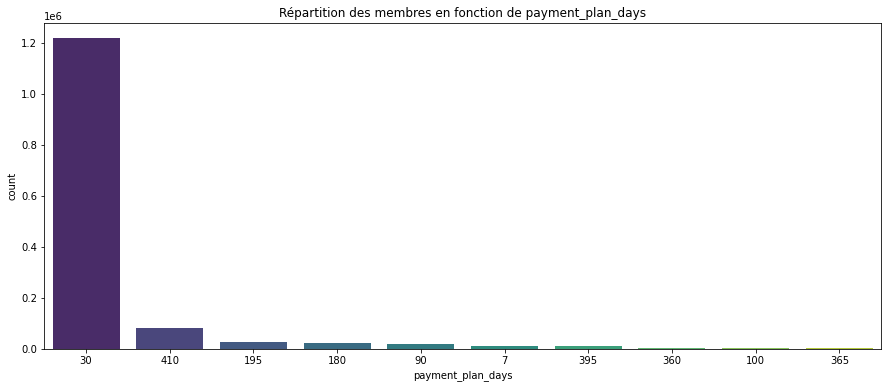

In [37]:
# Countplot sur payment_plan_days:
plt.figure(figsize = (15, 6))
sn.countplot(x='payment_plan_days', data = transactions, order = transactions.payment_plan_days.value_counts()[:10].index, palette = 'viridis').set_title('Répartition des membres en fonction de payment_plan_days')

plt.show()

### Analyse sur le prix d'abonnement des utilisateurs (*plan_list_price*)

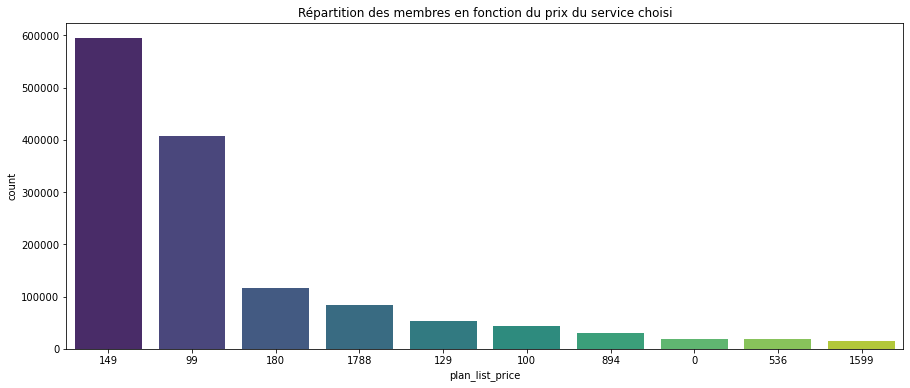

In [38]:
# Countplot sur plan_list_price:
plt.figure(figsize = (15, 6))
sn.countplot(x='plan_list_price', data = transactions, order = transactions.plan_list_price.value_counts()[:10].index, palette = 'viridis').set_title('Répartition des membres en fonction du prix du service choisi')
plt.show()

La majorité des utilisateurs utilisait la méthode de paiement 41, un abonnement de 30 jours, et payaient une offre de service généralement de 149 et 99 NTD durant le mois de Mars 2017.

### Analyse sur le prix d'abonnement des utilisateurs (*actual_amount_paid*)

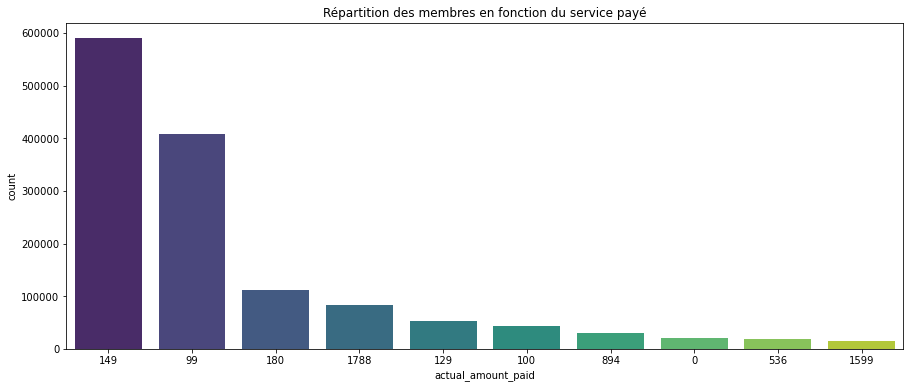

In [39]:
# Countplot sur actual_amount_paid:
plt.figure(figsize = (15, 6))
sn.countplot(x='actual_amount_paid', data = transactions, order = transactions.plan_list_price.value_counts()[:10].index, palette = 'viridis').set_title('Répartition des membres en fonction du service payé')
plt.show()

### Analyse sur le nombre de transactions

In [40]:
# Nombre de transactions par utilisateur:
transaction_count = transactions.groupby('msno').size().to_frame('transaction_count')
transaction_count = pd.merge(transactions, transaction_count, on='msno', how='inner')
transaction_count = transaction_count[['msno', 'transaction_count']]
transaction_count = transaction_count.groupby('msno').mean()

transactions = pd.merge(transactions, transaction_count, on='msno', how='inner')
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_count
0,UQ20ILS7d99X,32,90,298,298,0,20170131,20170504,0,1
1,uin/8esghpnq,41,30,149,149,1,20150809,20190412,0,39
2,uin/8esghpnq,41,30,149,149,1,20150107,20170612,0,39
3,uin/8esghpnq,41,30,149,149,1,20151009,20190911,0,39
4,uin/8esghpnq,41,30,149,149,1,20150207,20170910,0,39


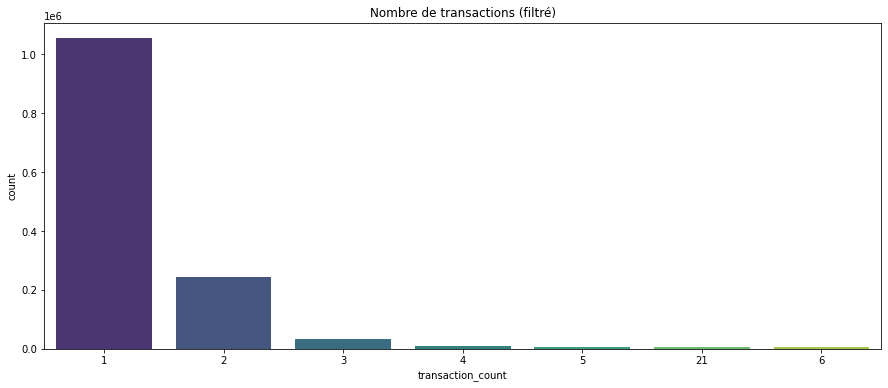

In [41]:
# Nombre de transaction par utilisateur sur le mois de Mars:
plt.figure(figsize = (15,6))
sn.countplot(x='transaction_count', data = transactions, order = transactions.transaction_count.value_counts()[:7].index, palette = 'viridis').set_title('Nombre de transactions (filtré)')
plt.show()

Les utilisateurs ont majoritairement effectué 1 transaction. Le maximum de transactions effectuées est de 208 pour un seul utilisateur à la fin de Juillet 2016. Cela peut être une anomalie lors de l'extraction des données. Sur l'exemple ci-dessous, la date d'expiration de l'adhésion semble aussi suspecte et des informations complémentaires devraient être apportées. En effet, l'offre adhérée est de 0, sans renouvellement de l'abonnement, et son expiration d'adhésion fluctue de façon incohérente.

In [42]:
MsnoMaxTransaction = transactions[transactions['msno']=='E/WoxAEYFn9L']
MsnoMaxTransaction.transaction_date.value_counts().to_frame('Transaction Count')

,Transaction Count
20160720,98
20160731,55
20160721,54
20160728,1


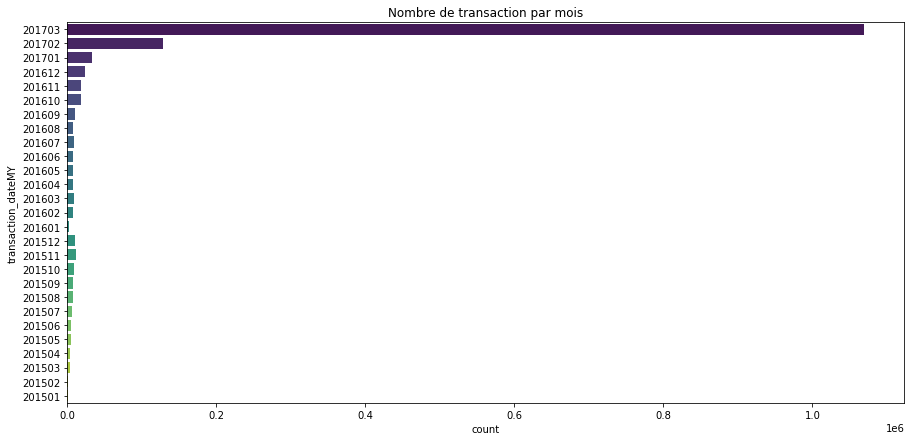

In [43]:
# Nombre de transaction sur le temps:
transactions['transaction_date'] = transactions['transaction_date'].astype(str)
transactions['transaction_dateMY'] = [int(i[:6]) for i in transactions['transaction_date']]

# Countplot sur transaction sur le temps:
fig, ax = plt.subplots(figsize = (15, 7))
sn.countplot(y = transactions['transaction_dateMY'].sort_values(), 
             order = transactions['transaction_dateMY'].sort_values().unique().tolist()[::-1],
             palette = 'viridis').set_title('Nombre de transaction par mois')
plt.show()

La majorité des transactions ont été effectuées durant le mois de Mars 2017. D'autres transactions comptabilisées ont été réalisées sur l'année précédente pour certains utilisateurs, remontant même à Janvier 2015. Ces données antérieures à l'année 2016 semblent représenter des anomalies lors de l'extraction des jeux de données qui ne devrait remonter seulement l'historique du début de l'année 2016.

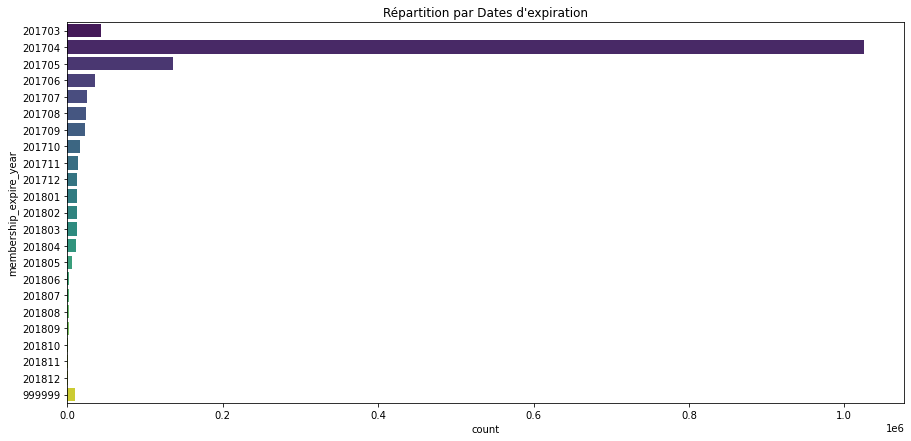

In [48]:
# Nombre Utilisateurs sur année d'expiration:
transactions['membership_expire_date_sr'] = transactions['membership_expire_date'].astype(str)
transactions['membership_expire_year'] = [int(i[:6]) for i in transactions['membership_expire_date_sr']]
transactions['membership_expire_year'] = [i if 201702 < i <= 201812 else 999999 for i in transactions['membership_expire_year']]

# Countplot sur transaction sur le temps:
fig, ax = plt.subplots(figsize = (15, 7))
sn.countplot(y = transactions['membership_expire_year'], palette = 'viridis').set_title('Répartition par Dates d\'expiration')
plt.show()

transactions = transactions.drop(['membership_expire_date_sr', 'membership_expire_year', 'transaction_dateMY'],1)

La plupart des Utilisateurs ont une date d'expiration sur l'année 2017, et particulièrement sur le mois d'Avril. Certains utilisateurs ont une date d'expiration allant jusqu'en 2036 et semblent être des anomalies car aucune offre d'abonnement cumulée ne peut amené à une telle date d'expiration.

### Analyse sur la proportion de renouvellement et d'annulation d'abonnement (*is_auto_renew* & *is_cancel*)

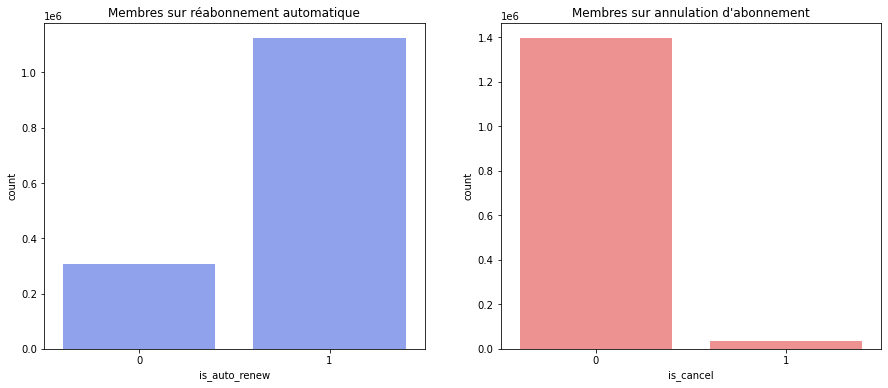

In [46]:
# Countplot sur is_auto_renew et is_cancel:
fig = plt.figure(figsize=(15, 6))
plt.subplot(121)
sn.countplot(transactions['is_auto_renew'], color = blue).set_title('Membres sur réabonnement automatique')
plt.subplot(122)
sn.countplot(transactions['is_cancel'], color = red).set_title('Membres sur annulation d\'abonnement')
plt.show()

### Merge Train et Transactions

In [49]:
# Merge Train et Members
MergeTrainTransactions = pd.merge(train, transactions, on='msno', how='inner')
print(f'Nombres de lignes :\t\t {len(MergeTrainTransactions)}')
print(f"Nombre d'utilisateur unique :\t {len(MergeTrainTransactions.msno.unique())}\n")

# Recherche de valeurs manquantes:
find_NaN(MergeTrainTransactions)

MergeTrainTransactions.head()

Nombres de lignes :		 1132036
Nombre d'utilisateur unique :	 933578

Aucune valeur manquante n'est détectée sur ce dataset


,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_count
0,INFEYZTR05pr,1,36,30,180,180,0,20170311,20170411,0,1
1,T1p21ltZC3Ch,1,17,60,0,0,0,20170311,20170314,0,2
2,T1p21ltZC3Ch,1,15,90,300,300,0,20170314,20170615,0,2
3,JKFrTc7iR9ZY,1,41,30,149,149,1,20150908,20170608,0,10
4,JKFrTc7iR9ZY,1,41,30,149,149,1,20150908,20170708,0,10


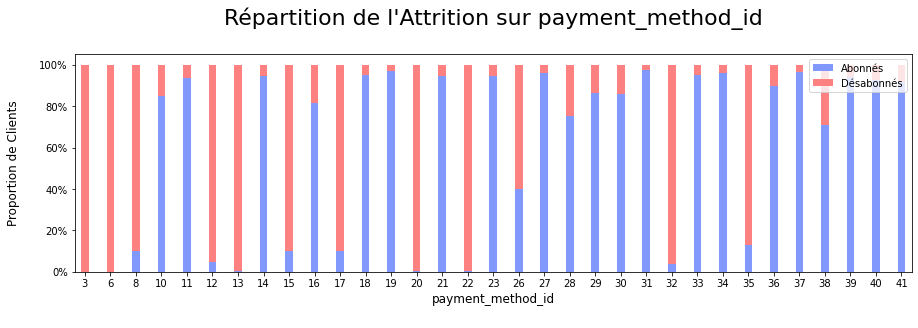

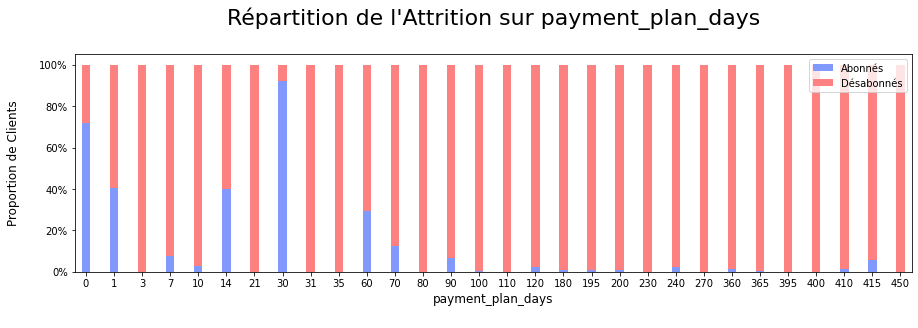

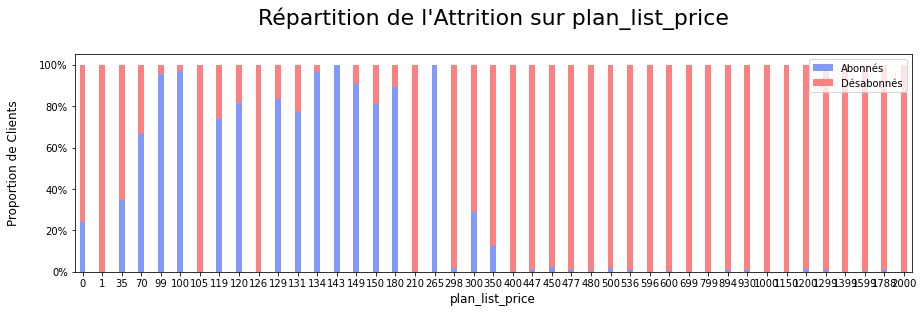

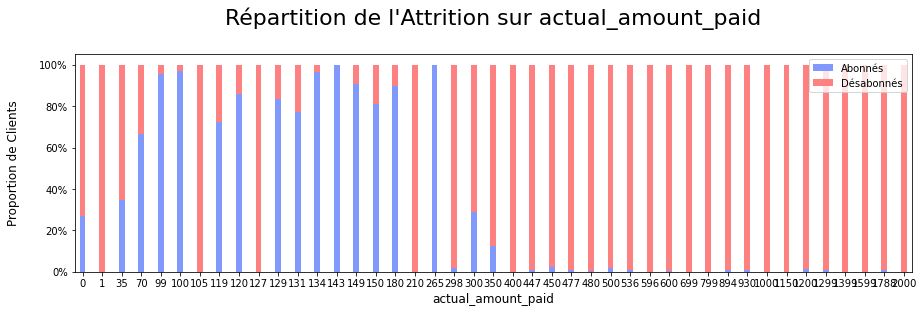

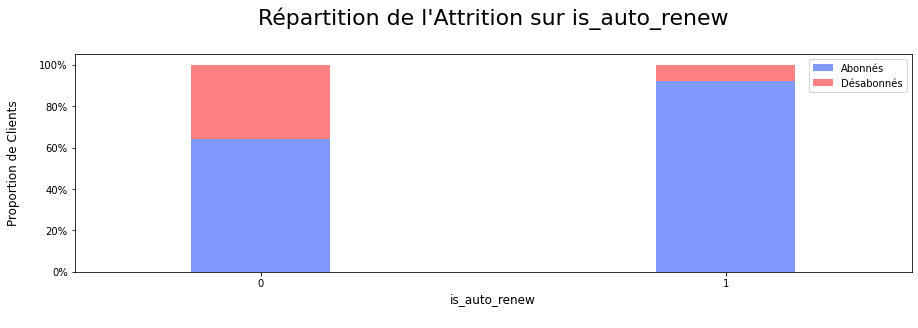

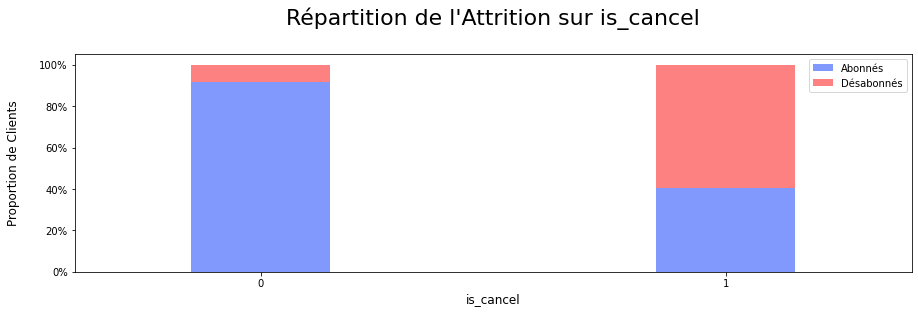

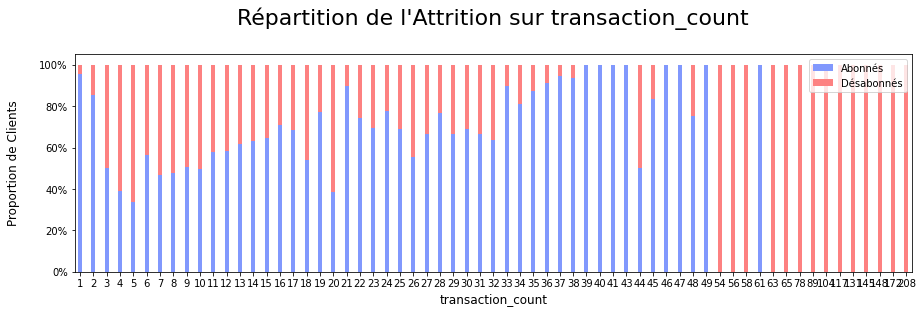

In [50]:
plot_churn(MergeTrainTransactions, 'payment_method_id')
plot_churn(MergeTrainTransactions, 'payment_plan_days')
plot_churn(MergeTrainTransactions, 'plan_list_price')
plot_churn(MergeTrainTransactions, 'actual_amount_paid')
plot_churn(MergeTrainTransactions, 'is_auto_renew')
plot_churn(MergeTrainTransactions, 'is_cancel')
plot_churn(MergeTrainTransactions, 'transaction_count')

**Payment_method_id** : Cette catégorie montre une certaine variabilité dans la proportion d'utilisateur quittant les services. Les clients qui utilisent certaines méthodes de paiement sont plus sujet à partir.

**Plan_list_price** : La proportion d'invidus en fonction de cette catégorie sur *is_churn* présente une grande variabilité.

**Actual_amount_paid** : Comme pour *Plan_list_price*, cette catégorie présente une forte variabilité de proportion entre utilisateurs restant et sortant. Naturellement, les abonnements payés par la plupart des utilisateurs s'élèvent à 149 NTD et 99 NTD. 

**Auto_renew et Is_cancel** : Ces variables présentent une corrélation notable respectivement négative et positive sur la propention à ce qu'un utilisateur arrête son abonnement.

**Transaction_count** : Cette catégorie présente une grande variabilité.

La proportion des désabonnés varie en fonction de la date d'expiration de leur abonnement. La plupart des utilisateurs ont une ou plusieurs date d'expiration d'abonnement au mois d'Avril (en fonction du nombre de transaction fait).

Il existe de nombreuses ambiguïtés sur le dataset Transactions. Certains utilisateurs présentent une date d'expiration d'abonnement très avancée dans le temps mais ils sont tout de même caractérisés comme désabonné. De plus le payment_plan_days de 30 jours et la date d'expiration de certains utilisateurs présentent des anomalies (cumule de jours d'abonnement et différence entre la dernière date de transaction et la date d'expiration ne corroborant pas). Aussi, selon les auteurs du dataset, des données de transactions manquent au delà du mois de Mars 2017. Ces données n'auront que peu d'intérêt dans la conception du modèle pour éviter tout biais.

## 4. Fusion des Datasets

In [89]:
# Merging :
Dataset = pd.merge(transactions, members, on='msno', how='inner')
Dataset = pd.merge(Dataset, logs, on='msno', how='inner')
Dataset = pd.merge(Dataset, train, on='msno', how='inner')

print(f"Nombre d'utilisateur :\t\t {len(Dataset)}")
print(f"Nombre d'utilisateur unique :\t {len(Dataset.msno.unique())}\n")

Dataset.head()

Nombre d'utilisateur :		 890959
Nombre d'utilisateur unique :	 725722



,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_count,city,bd,gender,registered_via,registration_init_time,registration_year,num_25Sum,num_50Sum,num_75Sum,num_985Sum,num_100Sum,num_unqSum,total_secsSum,num_25Mean,num_50Mean,num_75Mean,num_985Mean,num_100Mean,num_unqMean,total_secsMean,count,is_churn
0,fKrEDqYAzcSw,36,30,180,180,1,20170303,20170422,0,1,4,26,female,4,20161110,2016,71.0,37.0,13.0,14.0,773.0,806.0,190437.280,2.730769,1.423077,0.500000,0.538462,29.730769,31.000000,7324.510769,26,0
1,a4C9oNH3+Q8f,36,30,180,180,1,20170329,20170331,1,1,4,20,female,3,20140516,2014,91.0,30.0,15.0,15.0,480.0,488.0,136858.387,5.352941,1.764706,0.882353,0.882353,28.235294,28.705882,8050.493353,17,1
2,tnb65mPKPyeH,41,30,99,99,1,20170323,20170423,0,1,1,-1,NaN,7,20150823,2015,260.0,42.0,39.0,51.0,1387.0,916.0,344837.153,8.387097,1.354839,1.258065,1.645161,44.741935,29.548387,11123.779129,31,0
3,W08lTp3Lyz5G,41,30,149,149,1,20151112,20180613,0,19,1,-1,NaN,7,20130313,2013,8.0,1.0,1.0,2.0,126.0,135.0,29609.154,0.571429,0.071429,0.071429,0.142857,9.000000,9.642857,2114.939571,14,0
4,W08lTp3Lyz5G,41,30,149,149,1,20150412,20170411,0,19,1,-1,NaN,7,20130313,2013,8.0,1.0,1.0,2.0,126.0,135.0,29609.154,0.571429,0.071429,0.071429,0.142857,9.000000,9.642857,2114.939571,14,0


## 5. *Feature Engineering*
### Rapport Prix Abonnement et Temps d'abonnement
Ce service étant disponible dans de nombreux pays, le prix / jour peut différer et est peut-être une variable intéressante à prendre en compte, nous pouvons ainsi réaliser un rapport du prix de l'abonnement sur une journée.

In [96]:
# Feature Engineering___ Prix abonnement / Temps abonnement:
Price_per_day = []
for i, j in zip(Dataset.plan_list_price, Dataset.payment_plan_days):
    try:
        k = i/j
        Price_per_day.append(k)
    except:
        Price_per_day.append(0)

Dataset['price_per_day'] = Price_per_day

### Temps de fidelité *Membership_expire* et *Registration_init_time*

In [97]:
# Feature Engineering___ Différences entre membership_expire_date et registration_init_time en jour:

intermate_date3 = []
for i in Dataset['membership_expire_date']:
    s = str(i)
    date = datetime(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8]))
    intermate_date3.append(date)

Dataset['membership_expire_date_Date'] = intermate_date3

intermate_date4 = []
for i in Dataset['registration_init_time']:
    s = str(i)
    date = datetime(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8]))
    intermate_date4.append(date)

Dataset['registration_init_time_Date'] = intermate_date4

Dataset['days_fidelity'] = [difference_dates(i, j) for i, j in zip(Dataset.membership_expire_date_Date, Dataset.registration_init_time_Date)]

## 6. Traitement Final

In [99]:
Dataset = Dataset.drop(['registration_year','membership_expire_date_Date','registration_init_time_Date'],1)
Dataset = Dataset.loc[Dataset.groupby('msno')['membership_expire_date'].idxmax()]
Dataset.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_count,city,bd,gender,registered_via,registration_init_time,num_25Sum,num_50Sum,num_75Sum,num_985Sum,num_100Sum,num_unqSum,total_secsSum,num_25Mean,num_50Mean,num_75Mean,num_985Mean,num_100Mean,num_unqMean,total_secsMean,count,is_churn,price_per_day,days_fidelity
363420,+++IubgjAxvn,41,30,99,99,1,20170302,20170402,0,1,1,-1,NaN,7,20160503,200.0,47.0,42.0,39.0,747.0,684.0,220954.5830,6.896552,1.620690,1.448276,1.344828,25.758621,23.586207,7619.123552,29,0,3.300000,334
540084,+++KGJ1Vi2lH,37,30,149,149,1,20170307,20170406,0,1,4,27,male,7,20111001,212.0,37.0,38.0,34.0,401.0,585.0,116986.9040,7.851852,1.370370,1.407407,1.259259,14.851852,21.666667,4332.848296,27,0,4.966667,2014
569149,+++MqaETxAaV,41,30,99,99,1,20170327,20170427,0,1,1,-1,NaN,7,20151128,41.0,9.0,3.0,9.0,624.0,509.0,140733.2220,1.708333,0.375000,0.125000,0.375000,26.000000,21.208333,5863.884250,24,0,3.300000,516
243550,+++l4M/sEnP0,39,30,149,149,1,20170331,20170503,0,2,15,25,female,9,20160928,219.0,39.0,32.0,34.0,2201.0,1792.0,542811.6555,7.300000,1.300000,1.066667,1.133333,73.366667,59.733333,18093.721850,30,0,4.966667,217
889408,+++r/zNZrW5d,37,30,149,149,1,20170302,20170402,0,1,3,25,male,9,20070506,192.0,41.0,25.0,27.0,862.0,765.0,231866.1780,6.400000,1.366667,0.833333,0.900000,28.733333,25.500000,7728.872600,30,0,4.966667,3619


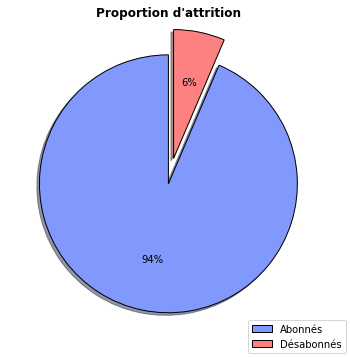

In [85]:
proportion_churn(Dataset)

Sur ce Dataset fusionné, près de 6% des utilisateurs n'ont pas renouvellé leur abonnement plus de 30 jours après la date d'expiration (et donc arrêt) de leur dernier abonnement.

# 7. Conclusion sur cette analyse globale

Dans la présente analyse sur les données qui serviront à l'entrainement du futur modèle, la majorité des features ont été étudiées afin d'en mesurer leur impact sur la valeur cible *is_churn*. Ces données features peuvent être de type quantitative comme celles retrouvées sur le journal des utilisateurs *User_logs* regroupant le temps d'écoute et le nombre de musique écouté. Des informations sur les transactions notament à travers *Payment_method_id*, *Plan_list_price*, *Transaction_date* sont aussi présents et mesure en soi l'activité de l'utilisateur au niveau de son abonnement au service. Ces données peuvent être sous forme de Date, de valeurs catégorielles ou quantitative discontinue (ordinalle). Des informations générales sur les membres sont aussi disponibles regroupant *Age*, *Genre*, *Ville*, *date d'enregistrement* et *expiration de l'abonnement*.

Les données sont comparés entre les deux "types de population" : les utilisateurs toujours abonnés et ceux ayant arrêté leur abonnement pour plus d'un mois.

### User Logs :

Les données de temps d'écoute et du nombre de musiques écoutés par jour sur le mois de Mars pour chaque utilisateur ont été additionnés. Les tests T ont montré des différences fortements significatives (à hauteur d'une erreur alpha à moins de 0,1%) entre les individus ayant stoppé leur abonnement et les individus encore abonnés. Ces variables seraient ainsi des marqueurs de choix afin de déterminer les futurs membres qui arrêteraient leur abonnement.


### Membres :

**City** : La ville 1 est la plus représenté dans le jeu de donnée. La proportion de gens *is_churn* = 0 et *is_churn* = 1 est similaire entre chaque ville, laissant supposé que la ville n'est pas un facteur de choix prépondérant dans la prédiction du futur modèle.

**Age** : Outre les valeurs abérrantes, les membres utilisant ce service sont majoritairement agés de 21 à 30 ans. La proportion d'utilisateur ayant une plus forte propention à quitter ces services sont agés de 10 à 20 ans. La proportion de membres se désabonnant pour plus de 30 jours est similaire dans les autres catégories d'âge.

**Genre** : La part d'utilisateurs qu'ils soient Homme ou Femme quittant les services de streaming est la même. Dans cette première analyse, le genre ne doit pas influencer sur le risque d'attrition.

**Méthode d'enregistrement** : La méthode d'enregistrement 7 est celle privilégiée par la plupart des utilisateurs. La proportion d'individus utilisant cette méthode est moins enclin à partir. A l'inverse, elle est plus importante sur la méthode d'enregistrement 4.

### Transactions :

**ID Méthode de Paiement** : Cette catégorie montre une certaine variabilité dans la proportion d'utilisateur quittant les services. Les clients qui utilisent certaines méthodes de paiement (3, 6, 8, 12, 13, 15, 17, 20, 22, 26, 32, 35) sont plus sujet à partir. La méthode 41 regroupe la plus grande proportion des utilisateurs.

**Plan_list_price** : La proportion d'invidus en fonction de cette catégorie sur *is_churn* présente une grande variabilité. Le prix d'abonnement le plus choisi par les utilisateurs et celui à 149 NTD suivi de 99 NTD.

**Actual_amount_paid** : Comme pour *Plan_list_price*, cette catégorie présente une forte variabilité de proportion entre utilisateurs restant et sortant. Naturellement, les abonnements payés par la plupart des utilisateurs s'élèvent à 149 NTD et 99 NTD. Il existe toutefois des différences de prix (*delta_paid*) entre ces deux variables et peut être du à d'éventuelles remises, ou paiements différés. Cette analyse a été effectuée en amont, lors d'une précédente étude, cependant, cette variable n'a pas été reproduite ici après avoir remarqué des incohérences sur ce dataset.

**Auto_renew et Is_cancel** : Ces variables présentent une corrélation notable respectivement négative et positive sur la propention à ce qu'un utilisateur arrête son abonnement.

### Variables créées :

**Price_per_day** : Les tests statistiques sur cette variable *Prix de l'abonnement à la journée* montre des différences significatives (à hauteur d'une erreur alpha à moins de 0,1%) entre les deux types d'utilisateurs.

**Fidelity_days** : Les utilisateurs désabonnés ont en moyenne été abonnés plus longtemps que ceux étant encore abonnés. Cette analyse est contre-intuitive mais pourrait s'expliquer par un désintérêt croissant des utilisateurs désabonnés au service de la plateforme. Elle peut aussi s'expliquer par des arrêts discontinues de l'abonnement, espaçant davantage l'utilisation des services proposés par la plateforme de streaming. C'est une variable relative avec les informations que dispose le jeu de donnée.

### Incohérences sur Transactions :

Plusieurs anomalies et incohérences ont été détectées sur ce dataset durant l'analyse. Cette variable ne contient pas toutes les dates de transaction de l'utilisateur (arrêt au 31-03-2017). La date d'expiration de l'abonnement sera la seule prise en compte.

## 8. Analyse sommaire des variables
### Sélection Univariée (*ANOVA*)
De nombreux tests statistiques différents peuvent être utilisés afin d'obtenir un aperçu des variables influants le plus sur la *Target*. La méthode ANOVA F-value est ici utilisée car appropriée pour les entrées numériques et les données nominales encodées.

In [157]:
Dataset = pd.read_csv('CSV_checkpoint/Dataset.csv')
Dataset

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_count,city,bd,gender,registered_via,registration_init_time,num_25Sum,num_50Sum,num_75Sum,num_985Sum,num_100Sum,num_unqSum,total_secsSum,num_25Mean,num_50Mean,num_75Mean,num_985Mean,num_100Mean,num_unqMean,total_secsMean,count,is_churn,price_per_day,days_fidelity
0,+++IubgjAxvn,41,30,99,99,1,20170302,20170402,0,1,1,-1,NaN,7,20160503,200.0,47.0,42.0,39.0,747.0,684.0,220954.5830,6.896552,1.620690,1.448276,1.344828,25.758621,23.586207,7619.123552,29,0,3.300000,334
1,+++KGJ1Vi2lH,37,30,149,149,1,20170307,20170406,0,1,4,27,male,7,20111001,212.0,37.0,38.0,34.0,401.0,585.0,116986.9040,7.851852,1.370370,1.407407,1.259259,14.851852,21.666667,4332.848296,27,0,4.966667,2014
2,+++MqaETxAaV,41,30,99,99,1,20170327,20170427,0,1,1,-1,NaN,7,20151128,41.0,9.0,3.0,9.0,624.0,509.0,140733.2220,1.708333,0.375000,0.125000,0.375000,26.000000,21.208333,5863.884250,24,0,3.300000,516
3,+++l4M/sEnP0,39,30,149,149,1,20170331,20170503,0,2,15,25,female,9,20160928,219.0,39.0,32.0,34.0,2201.0,1792.0,542811.6555,7.300000,1.300000,1.066667,1.133333,73.366667,59.733333,18093.721850,30,0,4.966667,217
4,+++r/zNZrW5d,37,30,149,149,1,20170302,20170402,0,1,3,25,male,9,20070506,192.0,41.0,25.0,27.0,862.0,765.0,231866.1780,6.400000,1.366667,0.833333,0.900000,28.733333,25.500000,7728.872600,30,0,4.966667,3619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725717,zzyhPtqzzcFP,39,30,149,149,1,20170228,20170406,0,2,6,24,male,9,20100825,131.0,37.0,27.0,39.0,198.0,379.0,68838.2960,5.240000,1.480000,1.080000,1.560000,7.920000,15.160000,2753.531840,25,1,4.966667,2416
725718,zzz/8Qro6SFD,40,30,149,149,1,20170322,20170422,0,1,13,-1,NaN,9,20110907,80.0,24.0,13.0,17.0,521.0,549.0,139711.1530,2.758621,0.827586,0.448276,0.586207,17.965517,18.931034,4817.625966,29,0,4.966667,2054
725719,zzzMgw6qohgE,41,30,149,149,1,20170327,20170428,0,1,1,-1,NaN,7,20100501,7.0,0.0,0.0,1.0,96.0,99.0,25106.7430,1.750000,0.000000,0.000000,0.250000,24.000000,24.750000,6276.685750,4,0,4.966667,2554
725720,zzzc2G7gQzlL,41,30,149,149,1,20170325,20170425,0,1,1,-1,NaN,7,20151219,45.0,32.0,17.0,10.0,205.0,283.0,58892.7080,2.812500,2.000000,1.062500,0.625000,12.812500,17.687500,3680.794250,16,0,4.966667,493


In [158]:
# Afin d'effectuer un futur encodage:
Dataset['city'] = [str(i)+'_city' for i in Dataset.city]
Dataset['payment_method_id'] = [str(i)+'_payment' for i in Dataset.payment_method_id]
Dataset['registered_via'] = [str(i)+'_register' for i in Dataset.registered_via]

# Encodage:
Dataset = pd.concat([Dataset, pd.get_dummies(Dataset.payment_method_id)],1)
Dataset = pd.concat([Dataset, pd.get_dummies(Dataset.registered_via)],1)
Dataset = pd.concat([Dataset, pd.get_dummies(Dataset.city)],1)
Dataset = Dataset.drop(['gender', 'payment_method_id','registered_via', 'city', 'transaction_date'], 1)

DatasetSoft, REM = train_test_split(Dataset, train_size=0.10, stratify = Dataset['is_churn'], random_state = 40)

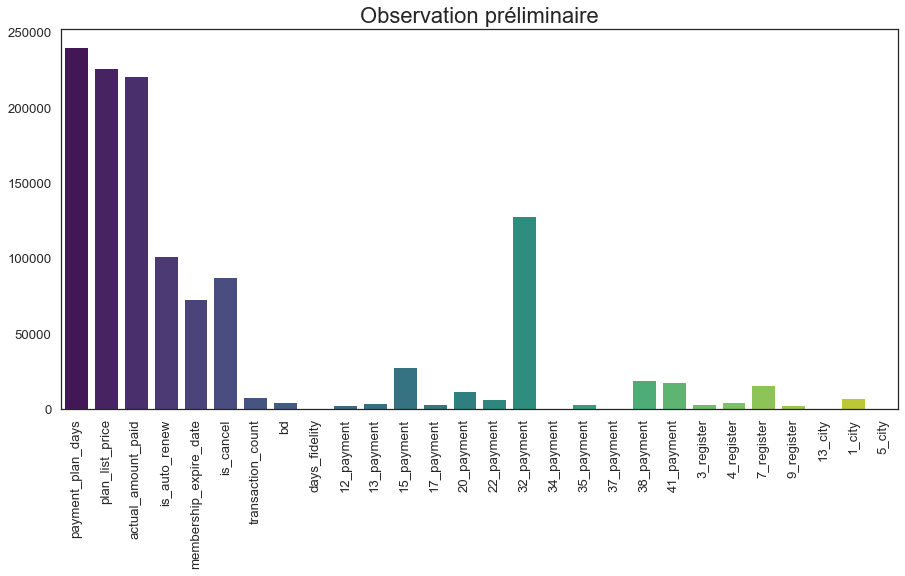

In [159]:
# Caractérisation des colonnes:
columns = list(DatasetSoft.columns.values)
columns.remove('is_churn')
columns.remove('msno')

# Standardisation:
sc_X = StandardScaler()
X = sc_X.fit_transform(Dataset[columns])
Y = Dataset['is_churn']

# Nombre de Features sélectionnées souhaitées:
top_k_vars = SelectKBest(f_classif)
top_k_vars.fit_transform(X, Y)

# Extraction des variables pour le plot:
fit = top_k_vars.fit(X, Y)

# Scores retranscrit sur le plot:
set_printoptions(precision=3)
Score_ANOVA = pd.Series([round(i,2) for i in fit.scores_.tolist()], index = columns)

# Sélection des meilleures variables:
BestOver800 = Score_ANOVA[Score_ANOVA.values > 800]

plt.figure(figsize = (15, 7))
sn.set(font_scale=1.2)
sn.set_style("white")
sn.barplot(BestOver800.index, BestOver800.values, palette = 'viridis')
plt.xticks(rotation=90)
plt.title('Observation préliminaire', horizontalalignment="center", fontstyle = "normal", fontsize="22", fontfamily = "sans-serif")
plt.show()

Les variables semblants influencer la *Target is_churn* à traver l'analyse de Variance univariée sont :

* **Payment_plan_days**
* **Plan_list_price** 
* **Actual_amount_paid**
* **Is_auto_renew**
* **Membership_expire_date** 
* **Is_cancel** 
* **Payment_method_ID**
* **bd**
* **Transaction_count**
* **City**

Une *Feature_importance* sur le modèle entrainé choisi sera effectué pour améliorer les prédiction de l'algorithme.